In [10]:
import time, pickle, re, sys, os, jsonlines, random, collections, math
from copy import deepcopy
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

gpu_id = '' #'1'
os.environ['CUDA_VISIBLE_DEVICES']=gpu_id       # do before importing torch

import torch
from torch import nn
import torch.nn.functional as F

In [7]:
data = torch.load('best_val_dss_weights.pt')
data.keys()

dict_keys(['imdb', 'listops', 'aan', 'cifar', 'pathfinder', 'sc', 'pathx'])

In [3]:
def hippo_skew_evals(N):
    x = 1 + 2*torch.arange(N, dtype=torch.float)
    Hippo = (x.view(-1,1) * x.view(1,-1)).sqrt().tril(diagonal=-1)
    evals = torch.linalg.eigvals((Hippo - Hippo.t()) / 2)
    # decreasing order of imag
    return evals[evals.imag.argsort(descending=True)]

N=64
Lambdas_orig = hippo_skew_evals(2*N)[:N] - .5

In [8]:
names = {'imdb': 'text', 'listops': 'listops', 'aan': 'retrieval', 'cifar': 'image', 
         'pathfinder': 'pathfinder', 'sc': 'sc', 'pathx': 'pathx'}

ds_lens = {'imdb': 2048, 'listops': 2000, 'aan': 4000, 'cifar': 1024, 
           'pathfinder': 1024, 'pathx': 16384, 'sc': 16000}

Lambdas = {'dataset': [], 'layer':[], 'real':[], 'imag':[]}

for i, (ds, ds_data) in enumerate(data.items()):
    # if ds not in ['aan', 'listops', 'sc', 'pathx']:
    #     continue
    ds_log_dt, ds_Lambda, ds_W = [], [], []
    for layer, weight in ds_data.items():
        if '.log_dt' in layer:
            ds_log_dt.append(weight)
        elif '.Lambda' in layer:
            ds_Lambda.append(weight)
        elif '.W' in layer:
            ds_W.append(weight)
        else:
            continue
        # print(ds, layer, weight.shape) 
    for il, Lam in enumerate(ds_Lambda):
        # Lam = ds_log_dt[il]#.exp()   # uncomment to plot log_dt
        Lam = Lam.numpy()
        Lambdas['real'].extend(Lam[...,0].reshape(-1))
        Lambdas['imag'].extend(Lam[...,1].reshape(-1))
        Lambdas['dataset'].extend([names[ds]]*Lam[...,0].size)
        Lambdas['layer'].extend([il]*Lam[...,0].size)

df_Lambdas = pd.DataFrame(Lambdas)
df_Lambdas['layer'] = df_Lambdas['layer'].astype(str)
df_Lambdas

,dataset,layer,real,imag
0,text,0,-0.397255,5214.697754
1,text,0,-0.856831,1736.765015
2,text,0,-0.576006,1040.418335
3,text,0,-0.797807,741.539490
4,text,0,-0.863112,574.870605
...,...,...,...,...
2555,pathx,5,-0.323174,2.581414
2556,pathx,5,-0.291901,1.931056
2557,pathx,5,-0.169505,0.927206
2558,pathx,5,-0.218141,1.028935


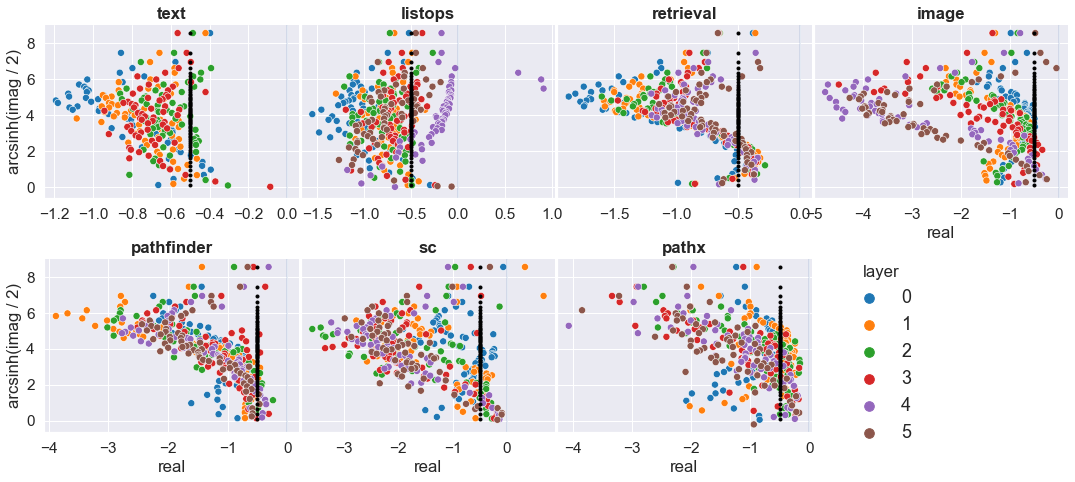

In [929]:
sns.set_theme()

df_Lambdas['layer'] = df_Lambdas['layer'].astype(int)
df_Lambdas['arcsinh(imag / 2)'] = np.arcsinh(df_Lambdas['imag']/2)  # pseudo-log
with sns.plotting_context("notebook", font_scale=1.4):
    g = sns.relplot(
            data=df_Lambdas, x="real", y="arcsinh(imag / 2)", height=3.5,
            col="dataset", hue="layer", #size="layer",
            kind="scatter", col_wrap=4, aspect=1.1, 
            # palette=sns.color_palette("flare", as_cmap=True).reversed(), s=50,
            facet_kws=dict(sharex=False, sharey=True), palette="tab10", s=50 
        )
    for ax in g.axes.flat:
        # skew hippo init
        ax.scatter(Lambdas_orig.view(-1).real, np.arcsinh(Lambdas_orig.view(-1).imag/2), color='black', marker='.', label='init')
   
    sns.move_legend(g, "lower right", bbox_to_anchor=(.8, .07), fontsize=18, markerscale=1.6)
    g.map(plt.axvline, alpha=.2).set_titles("{col_name}", weight='bold').tight_layout(w_pad=0)
    # plt.savefig('lambda.pdf', bbox_inches='tight')

# df_Lambdas['layer'] = df_Lambdas['layer'].astype(int)
# df_Lambdas['arcsinh(imag / 2)'] = np.arcsinh(df_Lambdas['imag']/2)
# with sns.plotting_context("notebook", font_scale=1.4):
#     g = sns.relplot(
#             data=df_Lambdas, x="real", y="layer", height=3.5,
#             col="dataset", hue="arcsinh(imag / 2)", kind="scatter", col_wrap=4, 
#             aspect=1.1, s=90, #hue_norm=(0, 300), 
#             facet_kws=dict(sharex=False),
#         palette=sns.color_palette("magma", as_cmap=True),
#         )
#     sns.move_legend(g, "lower right", bbox_to_anchor=(.8, .06), fontsize=18, markerscale=1.6)
#     g.map(plt.axvline, alpha=.2).set_titles("{col_name}", weight='bold').tight_layout(w_pad=0)
    # plt.savefig('lambda_real.pdf', bbox_inches='tight')

# plot kernels

In [11]:
def reciprocal(x, epsilon=1e-7, clamp=False):
    """ returns 1 / x, with bounded norm """
    x_conj = x.conj()
    norm_sq = (x*x_conj).real.clamp(epsilon) if clamp else (x*x_conj + epsilon)
    return x_conj / norm_sq

def dss_softmax_kernel(L, log_dt, Lambda, W):
    assert L >= 1
    assert Lambda.ndim == log_dt.ndim == 2
    if W.ndim == 4:
        assert W.shape[0] == 1
        W = W.squeeze(0)
    Lambda, W = map(torch.view_as_complex, (Lambda, W))              # [C H N]

    # Lambda.real * dt0  +  1j * Lambda.imag * dt1
    dt_Lambda = torch.view_as_complex(log_dt.exp().unsqueeze(1) 
                     * torch.view_as_real(Lambda).unsqueeze(0))      # [H N]

    P = dt_Lambda.unsqueeze(-1) * torch.arange(L, device=W.device)   # [H N L]

    # fast softmax using structure of P
    Lambda_gt_0 = Lambda.real > 0                                    # [N]
    if Lambda_gt_0.any():
        with torch.no_grad():
            P_max = dt_Lambda * (Lambda_gt_0 * (L-1))                # [H N]
        P = P - P_max.unsqueeze(-1)                                  # [H N L]
    S = P.exp()                                                      # [H N L]

    dt_Lambda_neg = dt_Lambda * (1 - 2*Lambda_gt_0)                  # [H N]
    # 1 / S.sum(-1) == num / den
    num = dt_Lambda_neg.exp() - 1                                    # [H N]
    den = (dt_Lambda_neg * L).exp() - 1                              # [H N]
    W = W * num * reciprocal(den * Lambda)                           # [C H N]

    return torch.einsum('hn,hnl->hl', W, S).real                     # [C H L]

imdb torch.Size([512, 2048]) 123.89999999999998 tensor(4.8828)


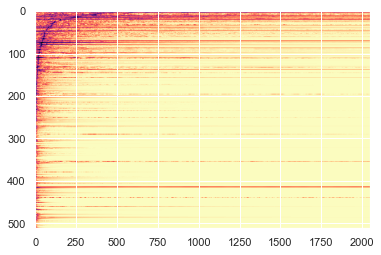

listops torch.Size([768, 2000]) 88.64999999999998 tensor(4.1667)


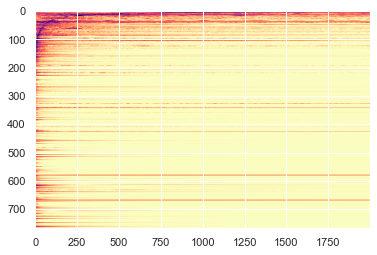

aan torch.Size([1536, 4000]) 155.25 tensor(6.7708)


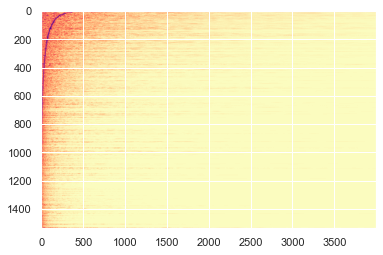

cifar torch.Size([3072, 1024]) 66.0 tensor(2.1159)


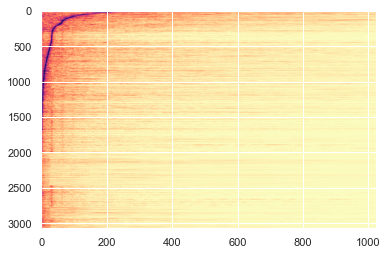

pathfinder torch.Size([1536, 1024]) 87.0 tensor(2.7344)


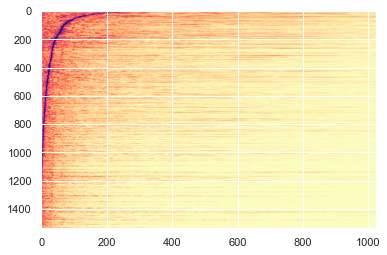

sc torch.Size([768, 16000]) 80.59999999999991 tensor(3.2552)


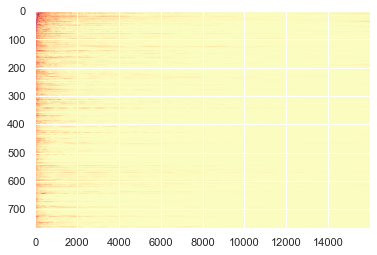

pathx torch.Size([1536, 16384]) 1268.75 tensor(25.4557)


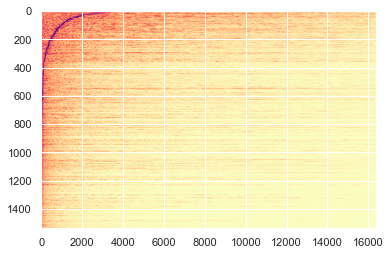

In [24]:
kernels = {}

for ds, ds_data in data.items():
    # if ds not in ['cifar', 'sc', 'pathx'] + ['listops', 'aan', 'pathfinder']:
    #     continue
        
    ds_log_dt, ds_Lambda, ds_W, ds_K = [], [], [], []
    for layer, weight in ds_data.items():
        if '.log_dt' in layer:
            ds_log_dt.append(weight)
        elif '.Lambda' in layer:
            ds_Lambda.append(weight)
        elif '.W' in layer:
            ds_W.append(weight)
        else:
            continue
        # print(ds, layer, weight.shape)
    assert len(ds_log_dt) ==  len(ds_Lambda) == len(ds_W)
    for layer in range(len(ds_log_dt)):
        # kernels of this layer
        L = ds_lens[ds]
        K = dss_softmax_kernel(L, ds_log_dt[layer], ds_Lambda[layer], ds_W[layer])
        ds_K.append(K)
    K = torch.cat(ds_K, dim=0)
    print(ds, K.shape, np.percentile(K.abs().argmax(-1), q=95), (K.abs().argmax(-1) > 128).float().mean()*100)
    
    K = K[K.abs().argmax(-1).argsort(descending=True)]       # sort by argmax
    K = K / (K.abs().max(-1, keepdims=True).values + 1e-12)  # normalize by inf norm
     
    # plt.figure(figsize=(11,5))
    plt.imshow(K[:,:].abs(), cmap='magma_r', aspect='auto')
    kernels[names[ds]] = K
    plt.show()
    # break

In [26]:
del kernels['text']

/specific/netapp5/joberant/home/ankitg/miniconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  del sys.path[0]


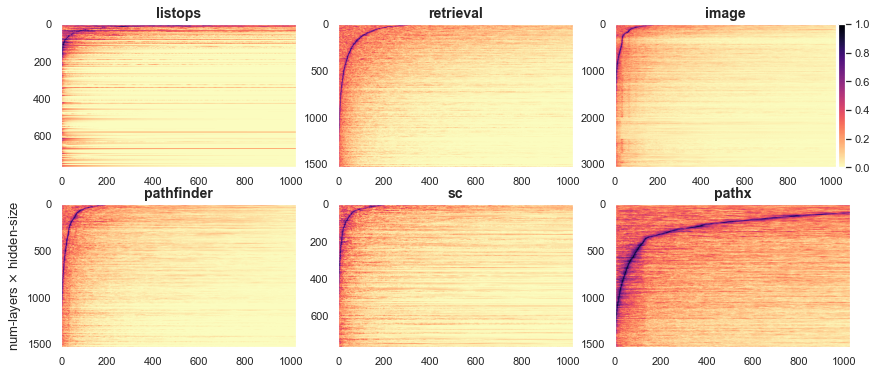

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(12,5))

# find minimum of minima & maximum of maxima
vmin = np.min([K.abs().min() for K in kernels.values()])
vmax = np.max([K.abs().max() for K in kernels.values()])

for i, (ds, K) in enumerate(kernels.items()):
    i, j = i // 3, i % 3
    ax = axs[i][j]
    
    im = ax.imshow(K[:,:1024].abs(), cmap='magma_r', aspect='auto', vmin=vmin, vmax=vmax)
    if i == 0 and j == 2:
        plt.colorbar(im, ax=ax, fraction=0.05, pad=0.01)
    
    ax.set_title(ds, weight='bold', fontsize=14)
    if i == 1 and j == 0:
        ax.set_ylabel(r'num-layers $\times$ hidden-size', fontsize=13)
    ax.grid(False)
    
fig.tight_layout(pad=0)
# plt.savefig(f"scaled_kernel_abs_heatmap.pdf", bbox_inches='tight')